In [1]:
renv::init('/oak/stanford/groups/agitler/Shared/Shared_Jupyter_Notebook_Analysis/4.1.1-OG/')

In [ ]:
library(dplyr)
library(Seurat)
library(ggplot2)
library(ggrepel)
library(pheatmap)
library(gplots)
library(svglite)
library(ggrastr)
library(matrixStats)

In [3]:
library(future)
plan("multicore", workers = availableCores())
options(future.globals.maxSize= +Inf)

## Save Directories for Figs + Tables

In [4]:
fig_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/Figure_Panels'
csv_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/CSV_Files'

## Custom Functions:

In [5]:
make_volcano_plot <- function(data, labeled_pts, labeled_genes=c(), p_val_cutoff=0.05, upper_log2FC_cutoff=0, lower_log2FC_cutoff=0) {
    data <- data %>% 
    mutate(
        Expression = case_when(avg_log2FC >= upper_log2FC_cutoff & p_val_adj <= p_val_cutoff ~ "Up-regulated",
                           avg_log2FC <= lower_log2FC_cutoff & p_val_adj <= p_val_cutoff ~ "Down-regulated",
                           TRUE ~ "Unchanged")
    )
    

    top <- labeled_pts
   
    top_genes <- bind_rows(
      data %>% 
        filter(Expression == 'Up-regulated') %>% 
        arrange(p_val_adj, desc(abs(avg_log2FC))) %>% 
        head(top),
      data %>% 
        filter(Expression == 'Down-regulated') %>% 
        arrange(p_val_adj, desc(abs(avg_log2FC))) %>% 
        head(top),
      data %>% 
        filter(gene %in% labeled_genes)
    )
    

    x_scale <- max(abs(data$avg_log2FC))
    
    p1 <- ggplot(data, aes(avg_log2FC, -log(p_val_adj,10))) + # -log10 conversion 
        geom_point(aes(color = Expression), size = 4/5) +
        geom_label_repel(data = top_genes, mapping = aes(avg_log2FC, -log(p_val_adj,10), label = gene),
                        size = 4, max.overlaps=18)+
        xlim(-x_scale,x_scale)+
        xlab(expression("log"[2]*"FC")) + 
        ylab(expression("-log"[10]*"(p adj)")) + 
        scale_color_manual(values = c("dodgerblue3", "gray50", "firebrick3")) + 
        guides(colour = guide_legend(override.aes = list(size=1.5)))  + 
        theme_classic() +
        theme(axis.text = element_text(size = 15), axis.title = element_text(size = 15))       
p1  
}

## Data Loading and Pre-Processing

In [6]:
data_dir <- '/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Cerv_131_aggr/outs/count/filtered_feature_bc_matrix'
gautier <- Read10X(data.dir = data_dir) %>% CreateSeuratObject()

In [7]:
# Remove mitochondrial reads
counts <- GetAssayData(gautier, assay = "RNA")
mito_genes <- grep( "^MT-", rownames(gautier), value = T)
counts <- counts[-(which(rownames(counts) %in% mito_genes)),]
gautier <- subset(gautier, features = rownames(counts))

In [8]:
# Normalize, identify variable features, and scale the data
gautier <- NormalizeData(gautier, normalization.method = "LogNormalize", scale.factor = 10000)
gautier <- FindVariableFeatures(gautier, selection.method = "vst", nfeatures = 33000)
all.genes <- rownames(gautier)
gautier <- ScaleData(gautier, features = all.genes)

Centering and scaling data matrix



In [ ]:
# PCA
gautier <- RunPCA(gautier, features = VariableFeatures(object = gautier))

In [ ]:
# Cluster
gautier <- FindNeighbors(gautier, dims = 1:20)
gautier <- FindClusters(gautier, resolution = 0.5)

In [ ]:
# UMAP
gautier <- RunUMAP(gautier, dims = 1:20)

### Figure S1A (left)

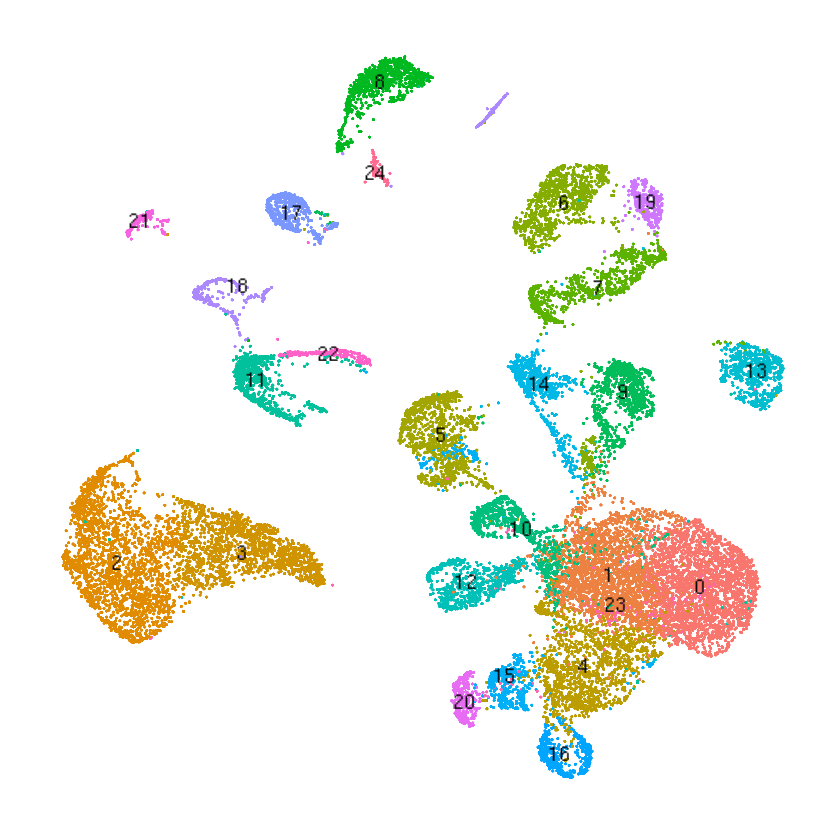

In [12]:
gautier_UMAP <- DimPlot(gautier, reduction = "umap", label = TRUE) + NoAxes() + NoLegend()
gautier_UMAP <- rasterize(gautier_UMAP, layers='Point', dpi=500)
gautier_UMAP

In [13]:
ggsave(gautier_UMAP, filename = paste(fig_dir, 'gautier_UMAP.svg', sep='/'), device='svg', width = 3, height = 3, units = "in")

## Cell class heatmap

### Cell type marker genes

In [14]:
neuron_marker <- c('RBFOX3')
astro_marker <- c('AQP4')
microglia_marker <- c('CSF1R')
endo_marker <- c('FLT1')
oligo_marker <- c('MOBP')
cholin_marker <- c('SLC5A7')
opc_fibro_marker <- c('PDGFRA')
debris_marker <- c('NEFH')

all.markers <- c(oligo_marker, astro_marker, microglia_marker, opc_fibro_marker, endo_marker, 
                 neuron_marker, cholin_marker, debris_marker)

In [15]:
Idents(gautier) <- gautier$seurat_clusters
heatmap.avgexp <- AverageExpression(gautier, features=all.markers)

### Average UMI count per cluster

In [16]:
avg_nCount_RNA <- gautier@meta.data %>% dplyr::group_by(seurat_clusters) %>% dplyr::summarise(dplyr::across(nCount_RNA, ~ mean(.))) %>% as.data.frame()

### Get proportion of intron-containing reads and add as meta data

In [17]:
S1_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Cerv_131_with_introns/S1_Cerv_131/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
S1_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Cerv_131_without_introns/S1_Cerv_131_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [18]:
S2_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Cerv_131_with_introns/S2_Cerv_131/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
S2_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Cerv_131_without_introns/S2_Cerv_131_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [19]:
S1_with_introns$barcode <- rownames(S1_with_introns@meta.data)
S1_without_introns$barcode <- rownames(S1_without_introns@meta.data)

In [20]:
S2_with_introns$barcode <- rownames(S2_with_introns@meta.data)
S2_with_introns@meta.data <- S2_with_introns@meta.data %>% mutate(barcode = stringr::str_replace(barcode, "1", "2"))
S2_with_introns <- RenameCells(S2_with_introns, new.names = S2_with_introns$barcode) 

In [21]:
S2_without_introns$barcode <- rownames(S2_without_introns@meta.data)
S2_without_introns@meta.data <- S2_without_introns@meta.data %>% mutate(barcode = stringr::str_replace(barcode, "1", "2"))
S2_without_introns <- RenameCells(S2_without_introns, new.names = S2_without_introns$barcode) 

In [22]:
with_introns <- dplyr::bind_rows(S1_with_introns@meta.data, S2_with_introns@meta.data)
without_introns <- dplyr::bind_rows(S1_without_introns@meta.data, S2_without_introns@meta.data)

In [23]:
prop_intronic <- inner_join(with_introns, without_introns, by = "barcode")

In [24]:
prop_intronic$prop_intronic <- (prop_intronic$nCount_RNA.x - prop_intronic$nCount_RNA.y)/prop_intronic$nCount_RNA.x

In [25]:
rownames(prop_intronic) <- prop_intronic$barcode
prop_intronic <- prop_intronic %>% dplyr::select(prop_intronic) %>% dplyr::filter(rownames(.) %in% rownames(gautier@meta.data))

In [26]:
gautier_prop_intronic <- AddMetaData(gautier, prop_intronic)

### Average proportion of intron-containing reads per cluster

In [27]:
avg_prop_intronic <- gautier_prop_intronic@meta.data %>% dplyr::group_by(seurat_clusters) %>% dplyr::summarise(dplyr::across(prop_intronic, ~ mean(.))) %>% as.data.frame()

### Combine data and make heatmap

In [28]:
heatmap.combo <- as.data.frame(t(heatmap.avgexp$RNA))
heatmap.combo$seurat_clusters <- rownames(heatmap.combo)
heatmap.combo <- dplyr::full_join(heatmap.combo, avg_nCount_RNA, by = "seurat_clusters") %>% dplyr::full_join(., avg_prop_intronic, by = "seurat_clusters") 
row.names(heatmap.combo) <- heatmap.combo$seurat_clusters
heatmap.combo <- dplyr::select(heatmap.combo, -seurat_clusters) %>% t(.)
heatmap.combo <- (heatmap.combo - rowMins(heatmap.combo))/(rowMaxs(heatmap.combo) - rowMins(heatmap.combo))

In [29]:
order <- c('2','3','17','8','21','18','6','19','14','16','0','23','1','20','12','15','4','9','10','13','5','7','24','11','22')
heatmap.combo <- heatmap.combo[,order]

### Figure S1B

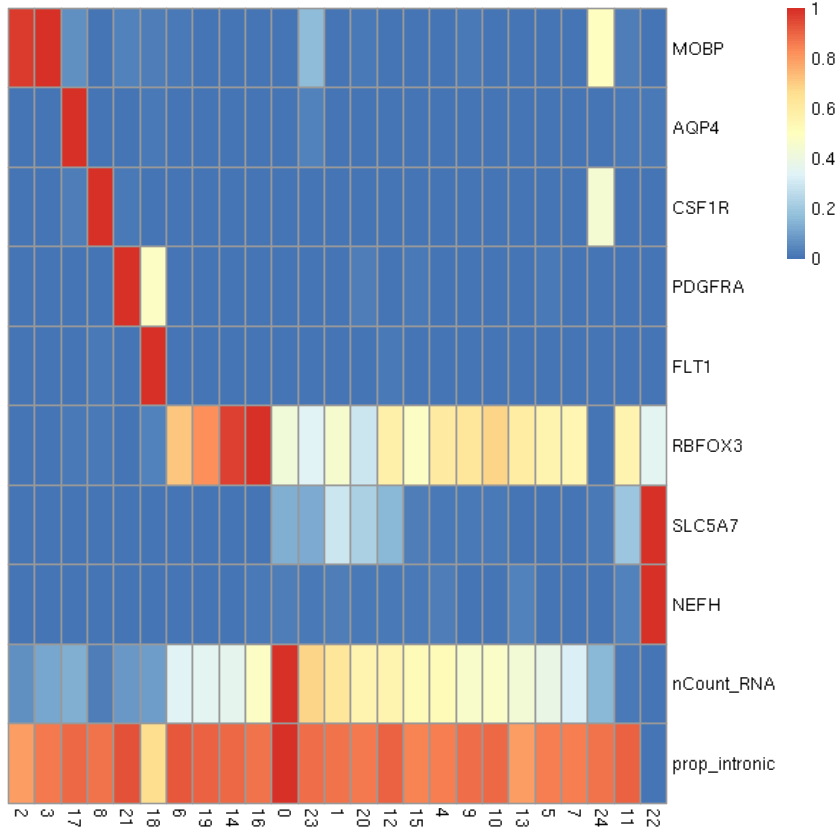

In [30]:
pheatmap(heatmap.combo, cluster_rows = FALSE, cluster_cols = FALSE)

In [31]:
pheatmap(heatmap.combo, cluster_rows = FALSE, cluster_cols = FALSE, filename = paste(fig_dir, 'cell_class_heatmap.pdf', sep='/'), width = 3.4, height = 1.6, fontsize = 7)

### Add cell class annotations (top_level_annotation) based on  heatmap results

In [32]:
gautier_prop_intronic$top_level_annotation <- "Neurons"
gautier_prop_intronic$top_level_annotation[gautier_prop_intronic$seurat_clusters %in% c("2", "3")] <- "Oligodendrocytes"
gautier_prop_intronic$top_level_annotation[gautier_prop_intronic$seurat_clusters %in% c("17")] <- "Astrocytes"
gautier_prop_intronic$top_level_annotation[gautier_prop_intronic$seurat_clusters %in% c("8")] <- "Microglia/Macrophages"
gautier_prop_intronic$top_level_annotation[gautier_prop_intronic$seurat_clusters %in% c("21")] <- "OPCs"
gautier_prop_intronic$top_level_annotation[gautier_prop_intronic$seurat_clusters %in% c("18")] <- "Endothelial Cells/Fibroblasts"
gautier_prop_intronic$top_level_annotation[gautier_prop_intronic$seurat_clusters %in% c("24")] <- "Non-Neuronal Doublets"
gautier_prop_intronic$top_level_annotation[gautier_prop_intronic$seurat_clusters %in% c("11")] <- "Low Quality Nuclei"
gautier_prop_intronic$top_level_annotation[gautier_prop_intronic$seurat_clusters %in% c("22")] <- "Non-Nuclear Debris"

### Figure S1A (right)

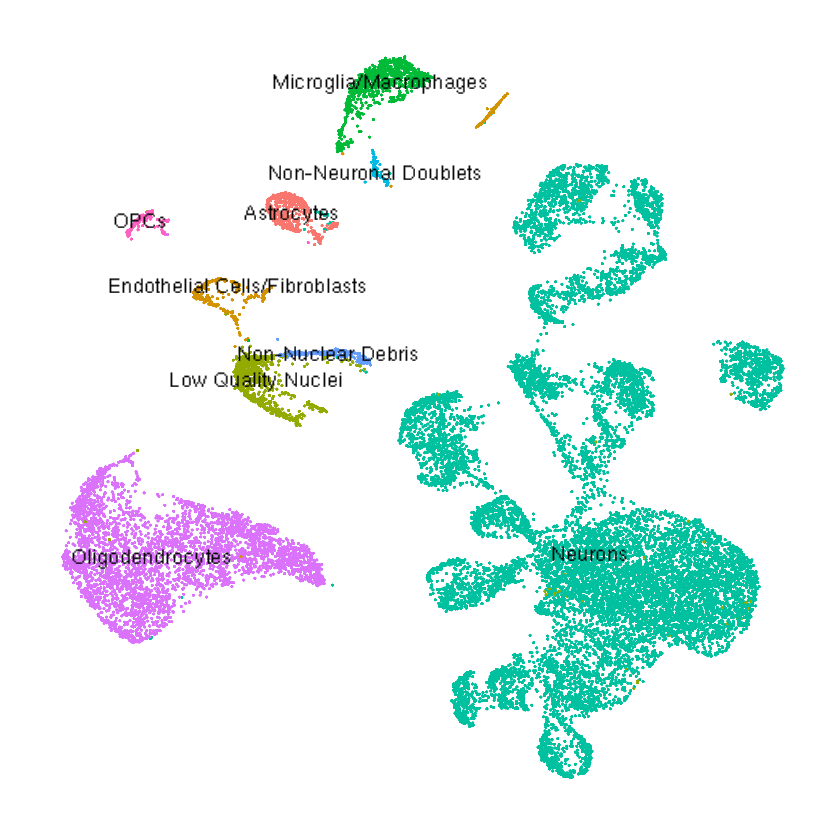

In [33]:
gautier_UMAP_labeled <- DimPlot(object = gautier_prop_intronic, reduction = 'umap', group.by = "top_level_annotation", label = TRUE) + NoAxes() + NoLegend() + theme(plot.title = element_blank())
gautier_UMAP_labeled <- rasterize(gautier_UMAP_labeled, layers='Point', dpi=500)
gautier_UMAP_labeled

In [34]:
ggsave(gautier_UMAP_labeled, filename = paste(fig_dir, 'gautier_UMAP_labeled.svg', sep='/'), device='svg', width = 3, height = 3, units = "in")

## Volcano plot - debris cluster 22

In [35]:
# Get number of cells per top_level_annotation 
table(gautier@meta.data$seurat_clusters)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
2486 2387 2247 1509 1423 1113 1061  875  875  874  865  834  733  632  624  531 
  16   17   18   19   20   21   22   23   24 
 488  482  381  313  285  218  214  163   84 

In [36]:
Idents(gautier) <- gautier$seurat_clusters
debris.markers <- FindMarkers(gautier, ident.1 = 22, max.cells.per.ident = 214, logfc.threshold=0, min.pct=0) 

### Table S7

In [37]:
write.csv(debris.markers, file=paste(csv_dir, 'Table S7.csv', sep='/'))

### Figure S1C

In [38]:
debris.markers$gene <- rownames(debris.markers)
rownames(debris.markers) <- NULL

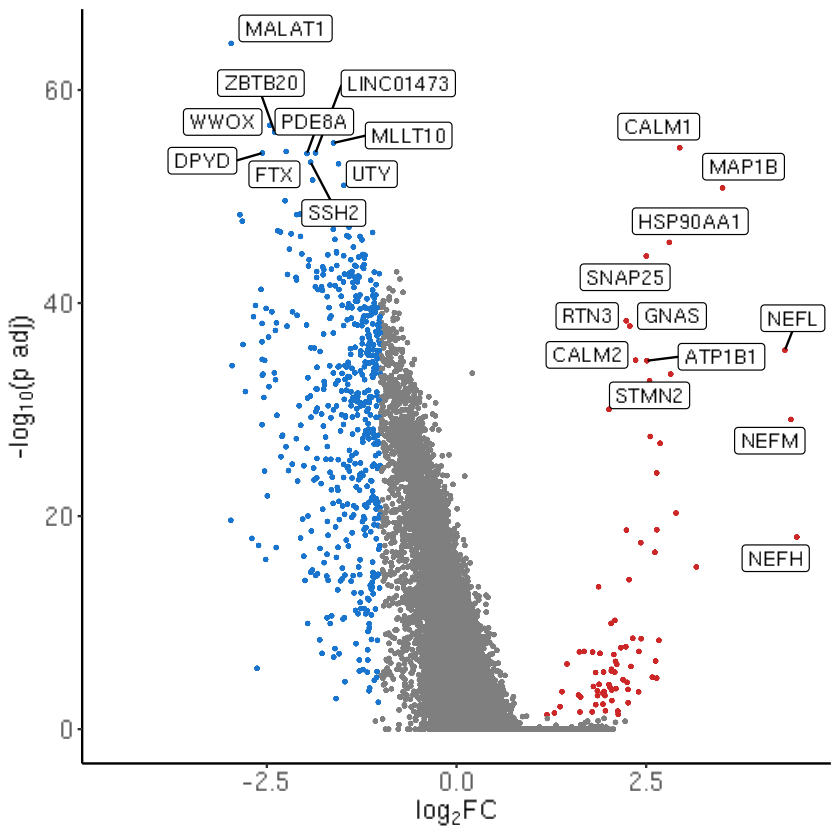

In [39]:
debris_volcano_markers <- make_volcano_plot(debris.markers, 10, labeled_genes = c("NEFH", "NEFM"), p_val_cutoff = 0.05, upper_log2FC_cutoff=1, lower_log2FC_cutoff=-1)
debris_volcano_markers <- rasterize(debris_volcano_markers, layers="Point", dpi=500) + NoLegend()
debris_volcano_markers

In [40]:
ggsave(debris_volcano_markers, filename = paste(fig_dir, 'debris_volcano_markers.svg', sep='/'), device='svg', width = 6.4, height = 4.848, units = "in")

## Subcluster neurons

In [41]:
Idents(gautier_prop_intronic) <- gautier_prop_intronic$top_level_annotation
gautier_neurons <- subset(gautier_prop_intronic, idents = "Neurons")

In [42]:
gautier_neurons <- FindVariableFeatures(gautier_neurons, selection.method = "vst", nfeatures = 33000)
all.genes <- rownames(gautier_neurons)
gautier_neurons <- ScaleData(gautier_neurons, features = all.genes)

Centering and scaling data matrix



In [ ]:
# PCA
gautier_neurons <- RunPCA(gautier_neurons, features = VariableFeatures(object = gautier_neurons))

In [ ]:
# Cluster
gautier_neurons <- FindNeighbors(gautier_neurons, dims = 1:50)
gautier_neurons <- FindClusters(gautier_neurons, resolution = 0.5)

In [ ]:
# UMAP
gautier_neurons <- RunUMAP(gautier_neurons, dims = 1:50)

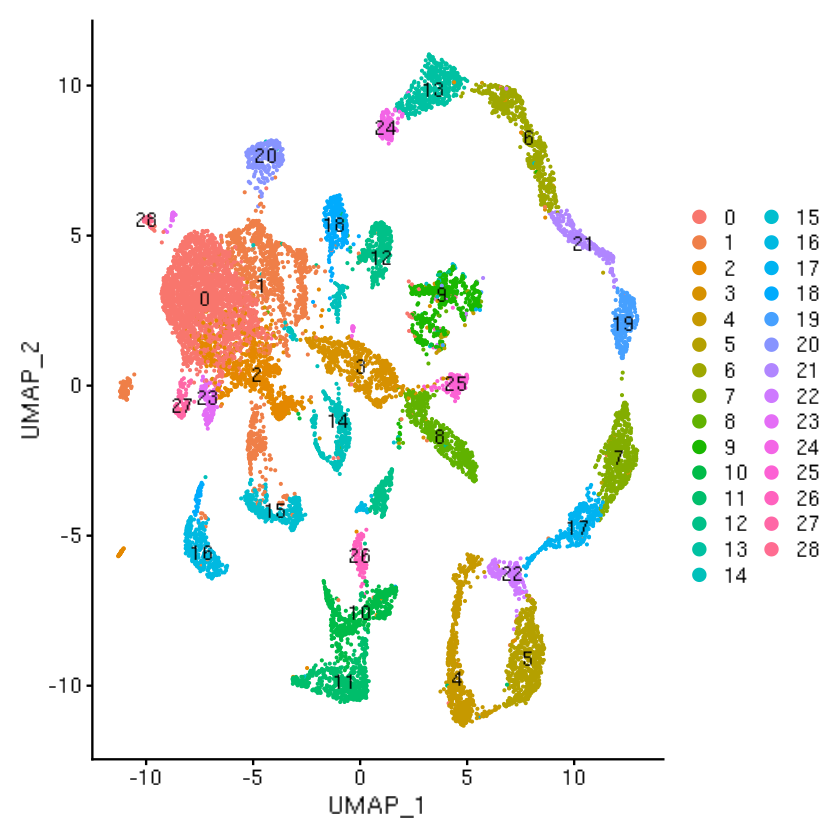

In [46]:
DimPlot(gautier_neurons, reduction = "umap", label = TRUE)

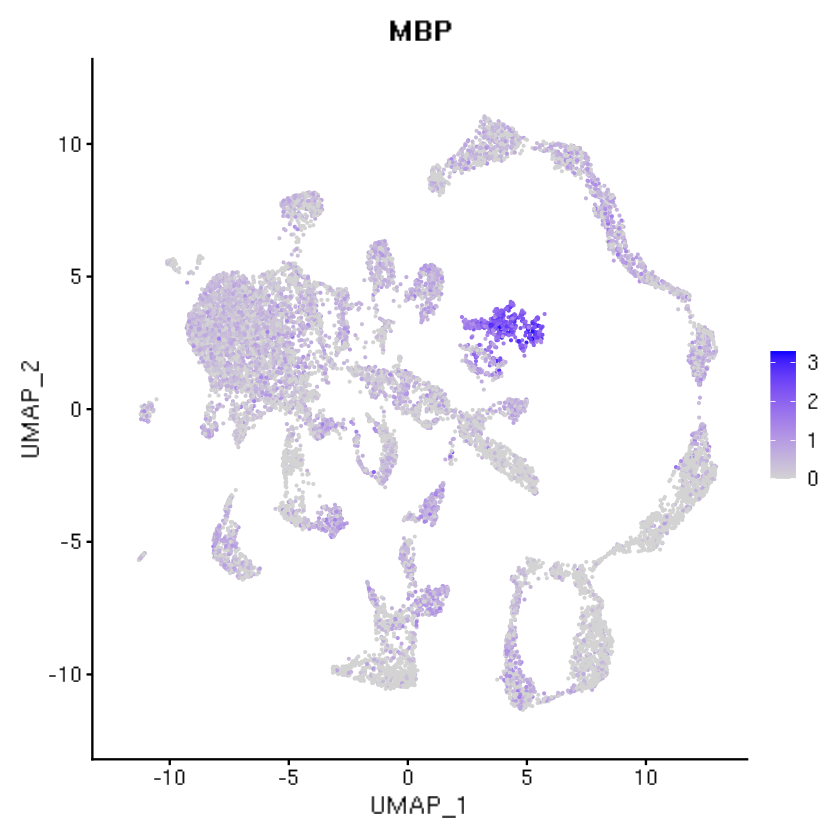

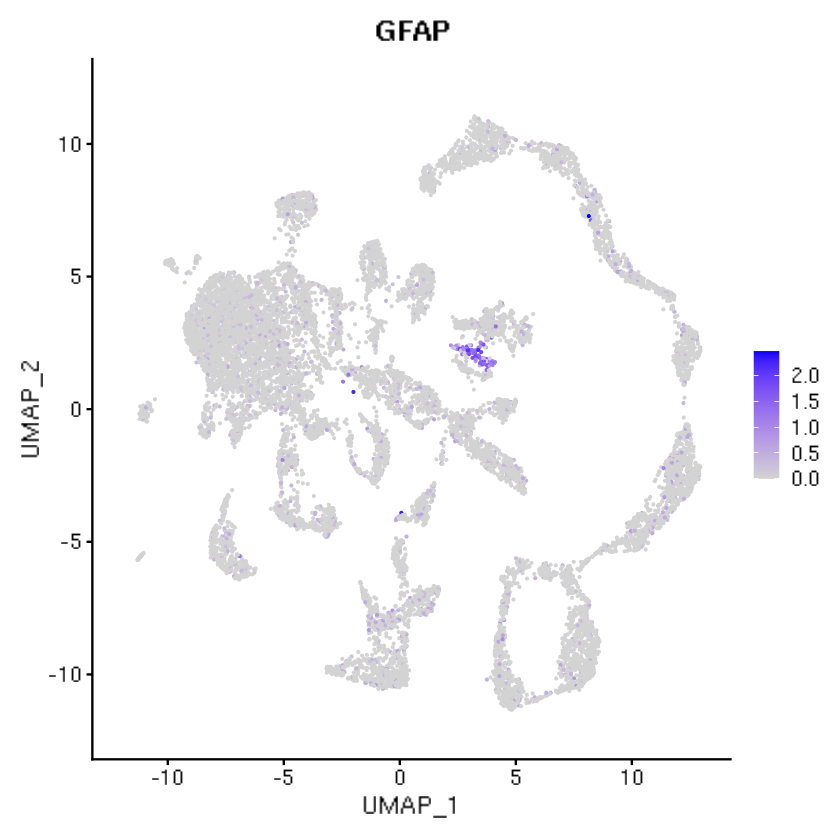

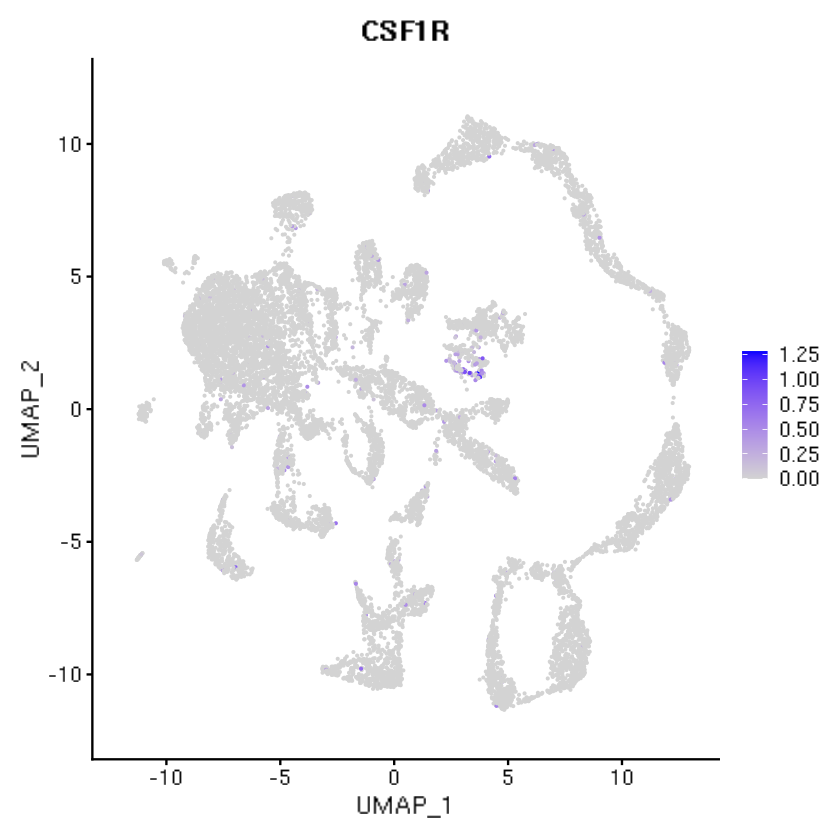

In [47]:
# Glial marker genes
FeaturePlot(gautier_neurons, features = c("MBP"))
FeaturePlot(gautier_neurons, features = c("GFAP"))
FeaturePlot(gautier_neurons, features = c("CSF1R"))

In [48]:
# Remove cluster 9 (glial/neuronal doublets) and re-analyze
gautier_neurons <- subset(gautier_neurons, idents = c("9"), invert = TRUE)

In [49]:
gautier_neurons <- FindVariableFeatures(gautier_neurons, selection.method = "vst", nfeatures = 33000)
all.genes <- rownames(gautier_neurons)
gautier_neurons <- ScaleData(gautier_neurons, features = all.genes)

Centering and scaling data matrix



In [ ]:
# PCA
gautier_neurons <- RunPCA(gautier_neurons, features = VariableFeatures(object = gautier_neurons))

In [ ]:
# Cluster
gautier_neurons <- FindNeighbors(gautier_neurons, dims = 1:50)
gautier_neurons <- FindClusters(gautier_neurons, resolution = 2.5)

In [ ]:
# UMAP
gautier_neurons <- RunUMAP(gautier_neurons, dims = 1:50)

### Figure 1B

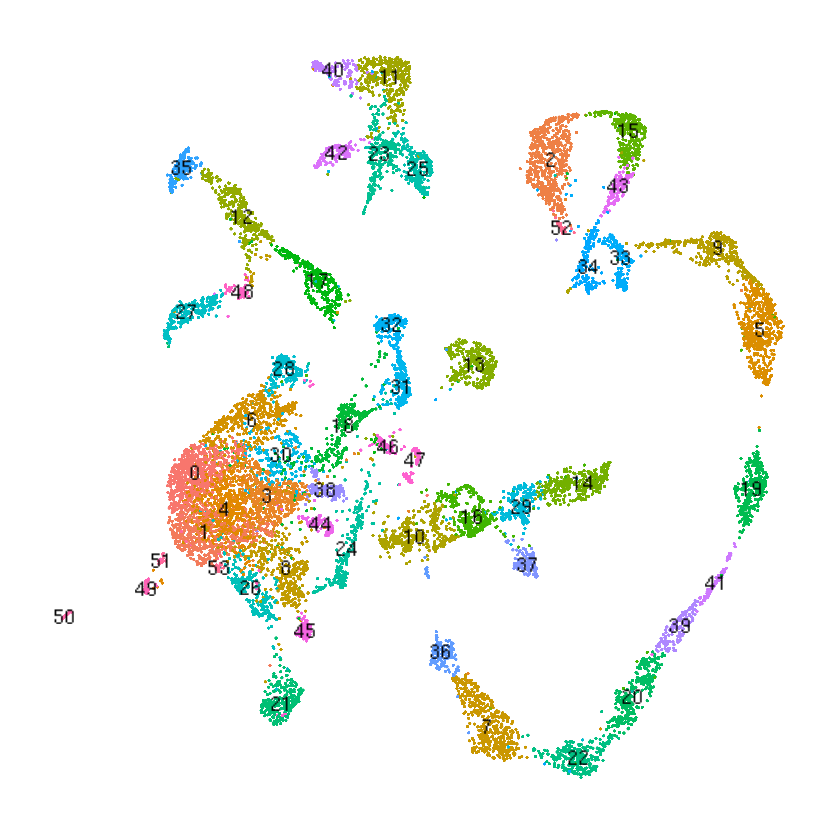

In [53]:
gautier_neurons_UMAP <- DimPlot(gautier_neurons, reduction = "umap", group.by = "seurat_clusters", label = TRUE) + NoAxes() + NoLegend() + theme(plot.title = element_blank())
gautier_neurons_UMAP <- rasterize(gautier_neurons_UMAP, layers='Point', dpi=1000)
gautier_neurons_UMAP

In [54]:
ggsave(gautier_neurons_UMAP, filename = paste(fig_dir, 'gautier_neurons_UMAP.svg', sep='/'), device='svg', width = 5.4, height = 4.8, units = "in")

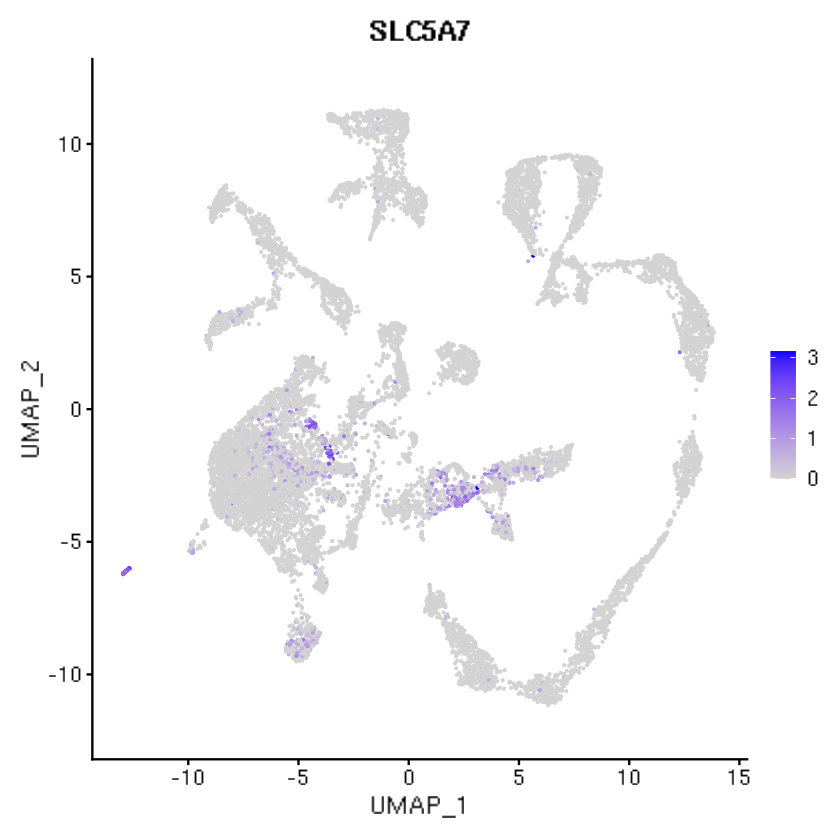

In [55]:
# Marker gene
FeaturePlot(gautier_neurons, features = c("SLC5A7"))

### Cluster 50 marker genes

In [56]:
Idents(gautier_neurons) <- gautier_neurons$seurat_clusters
cluster50.markers <- FindMarkers(gautier_neurons, ident.1 = 50, only.pos = TRUE)
head(cluster50.markers, n = 50)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AC013265.1,0.000000e+00,1.3798517,0.625,0.008,0.000000e+00
AMTN,0.000000e+00,4.0959122,0.700,0.001,0.000000e+00
AC096773.1,0.000000e+00,0.3953270,0.425,0.004,0.000000e+00
MNX1,0.000000e+00,0.2621736,0.600,0.006,0.000000e+00
IL33,0.000000e+00,0.5118036,0.625,0.004,0.000000e+00
COL1A1,0.000000e+00,0.3001079,0.450,0.003,0.000000e+00
GRIN3B,0.000000e+00,0.4045918,0.625,0.006,0.000000e+00
PRPH,1.085950e-299,0.4678286,0.600,0.009,3.973272e-295
PALMD,1.187001e-271,0.9149330,0.875,0.022,4.343001e-267


### Label cluster 50 as "Motor Neurons" and other clusters as "Other Neurons"

In [57]:
gautier_neurons$motor_neuron <- ifelse(gautier_neurons$seurat_clusters == "50", yes = "Motor Neurons", no = "Other Neurons")

## Violin plots - genes and UMIs per nucleus

### Normalized nFeature_RNA

In [58]:
median_nFeature <- filter(gautier_neurons@meta.data, motor_neuron == "Other Neurons") %>% {median(.$nFeature_RNA)}

In [59]:
median_nFeature

[1] 6495

In [60]:
filter(gautier_neurons@meta.data, motor_neuron == "Motor Neurons") %>% {median(.$nFeature_RNA)}

[1] 8384

In [61]:
gautier_neurons$norm_nFeature_RNA = gautier_neurons$nFeature_RNA/median_nFeature

### Figure 2A (left, top)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”


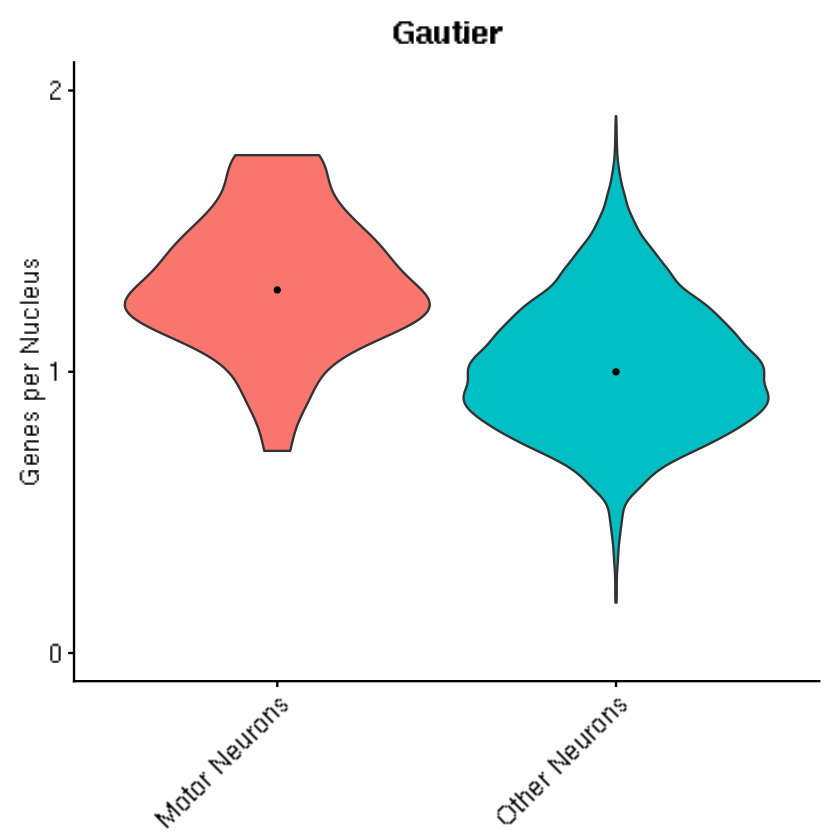

In [62]:
gautier_norm_nFeature_RNA <- VlnPlot(gautier_neurons, group.by = "motor_neuron", features = "norm_nFeature_RNA", pt.size = 0) + 
  labs(title = "Gautier", y = "Genes per Nucleus") + NoLegend() + FontSize(
  x.text = 15,
  y.text = 15,
  y.title = 15,
  main = 18,
) + scale_y_continuous(limits = c(0,2), breaks=c(0,1,2)) + stat_summary(fun = median, geom='point', size = 1) + theme(axis.title.x = element_blank())

gautier_norm_nFeature_RNA

In [63]:
ggsave(gautier_norm_nFeature_RNA, filename = paste(fig_dir, 'gautier_norm_nFeature_RNA.svg', sep='/'), device='svg', width = 3.4, height = 3.55, units = "in")

Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”


### Normalized nCount_RNA

In [64]:
median_nCount <- filter(gautier_neurons@meta.data, motor_neuron == "Other Neurons") %>% {median(.$nCount_RNA)}

In [65]:
median_nCount

[1] 21790

In [66]:
filter(gautier_neurons@meta.data, motor_neuron == "Motor Neurons") %>% {median(.$nCount_RNA)}

[1] 42241

In [67]:
gautier_neurons$norm_nCount_RNA = gautier_neurons$nCount_RNA/median_nCount

### Figure 2A (left, bottom)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



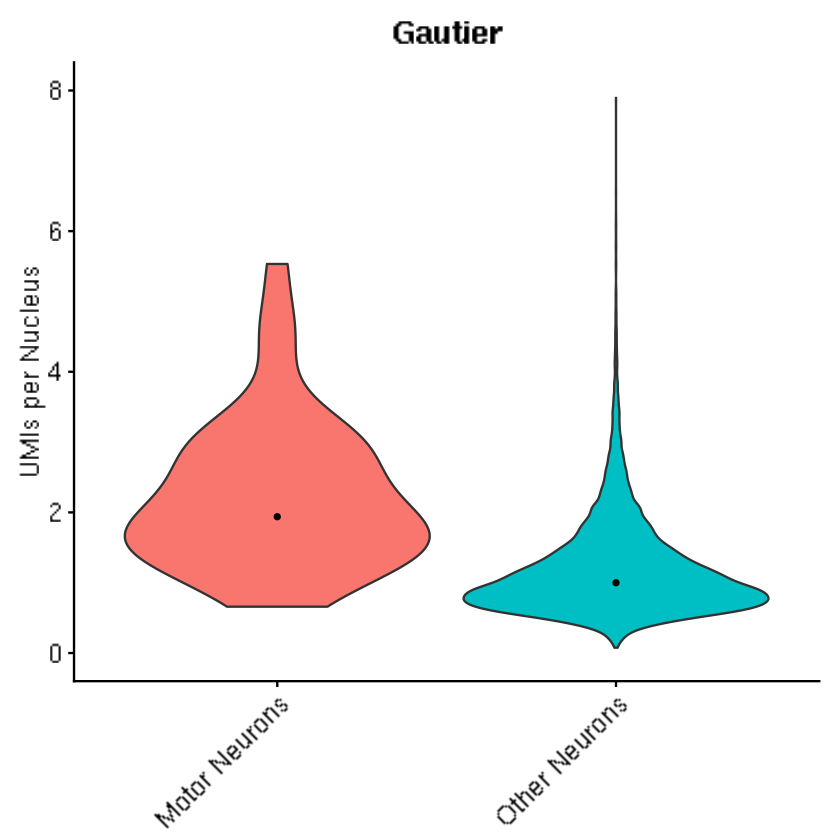

In [68]:
gautier_norm_nCount_RNA <- VlnPlot(gautier_neurons, group.by = "motor_neuron", features = "norm_nCount_RNA", pt.size = 0) + 
  labs(title = "Gautier", y = "UMIs per Nucleus") + NoLegend() + FontSize(
  x.text = 15,
  y.text = 15,
  y.title = 15,
  main = 18,
) + scale_y_continuous(limits = c(0,8)) + stat_summary(fun = median, geom='point', size = 1) + theme(axis.title.x = element_blank())

gautier_norm_nCount_RNA

In [69]:
ggsave(gautier_norm_nCount_RNA, filename = paste(fig_dir, 'gautier_norm_nCount_RNA.svg', sep='/'), device='svg', width = 3.4, height = 3.55, units = "in")

## Volcano plot - motor neurons vs. other neurons

In [70]:
Idents(gautier_neurons) <- gautier_neurons$motor_neuron
mn.markers <- FindMarkers(gautier_neurons, ident.1 = "Motor Neurons", ident.2 = "Other Neurons", max.cells.per.ident = 500, logfc.threshold = 0, min.pct = 0)

### Table S1

In [71]:
write.csv(mn.markers, file=paste(csv_dir, 'Table S1.csv', sep='/'))

### Figure 1C

In [72]:
mn.markers$gene <- rownames(mn.markers)
rownames(mn.markers) <- NULL

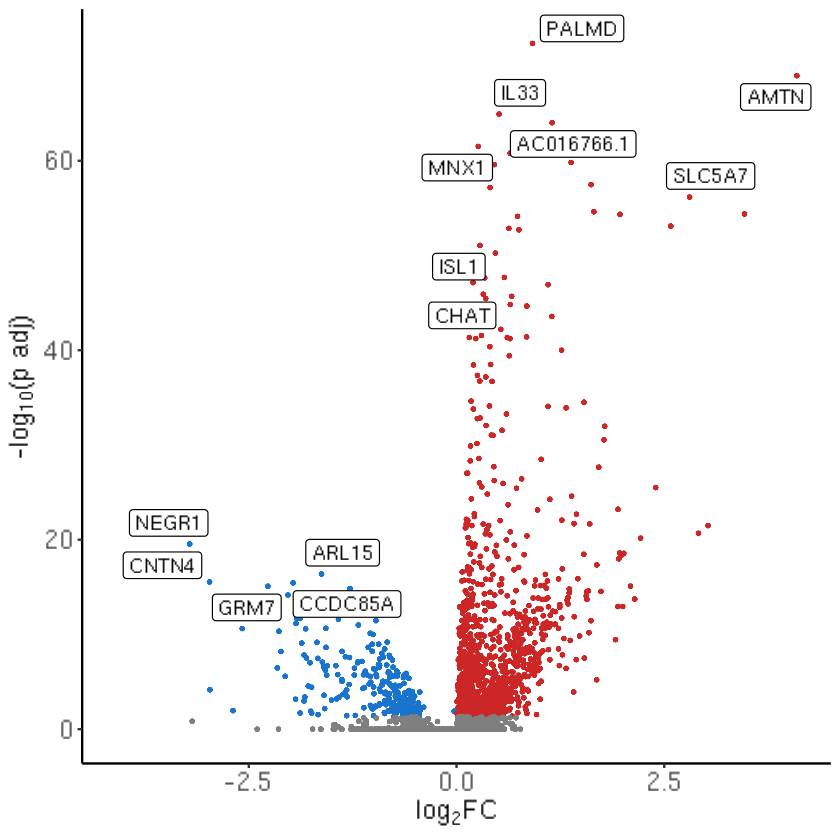

In [73]:
gautier_mn_volcano_plot <- make_volcano_plot(mn.markers, 5, labeled_genes = c('SLC5A7', 'ISL1', 'CHAT'), p_val_cutoff = 0.05)
gautier_mn_volcano_plot <- rasterize(gautier_mn_volcano_plot, layers="Point", dpi=500) + NoLegend()
gautier_mn_volcano_plot

In [74]:
ggsave(gautier_mn_volcano_plot, filename = paste(fig_dir, 'gautier_mn_volcano_plot.svg', sep='/'), device='svg', width = 6.4, height = 4.848, units = "in")

## Subcluster motor neurons

In [75]:
Idents(gautier_neurons) <- gautier_neurons$motor_neuron
gautier_mns <- subset(gautier_neurons, idents = "Motor Neurons")

In [ ]:
gautier_mns <- FindVariableFeatures(gautier_mns, selection.method = "vst", nfeatures = 40)
all.genes <- rownames(gautier_mns)
gautier_mns <- ScaleData(gautier_mns, features = all.genes)

In [ ]:
# PCA
gautier_mns <- RunPCA(gautier_mns, features = VariableFeatures(object = gautier_mns), approx = FALSE)

In [ ]:
# Cluster
gautier_mns <- FindNeighbors(gautier_mns, dims = 1:2)
gautier_mns <- FindClusters(gautier_mns, resolution = 0.4, graph.name = "RNA_snn")

## Motor neuron UMAPs

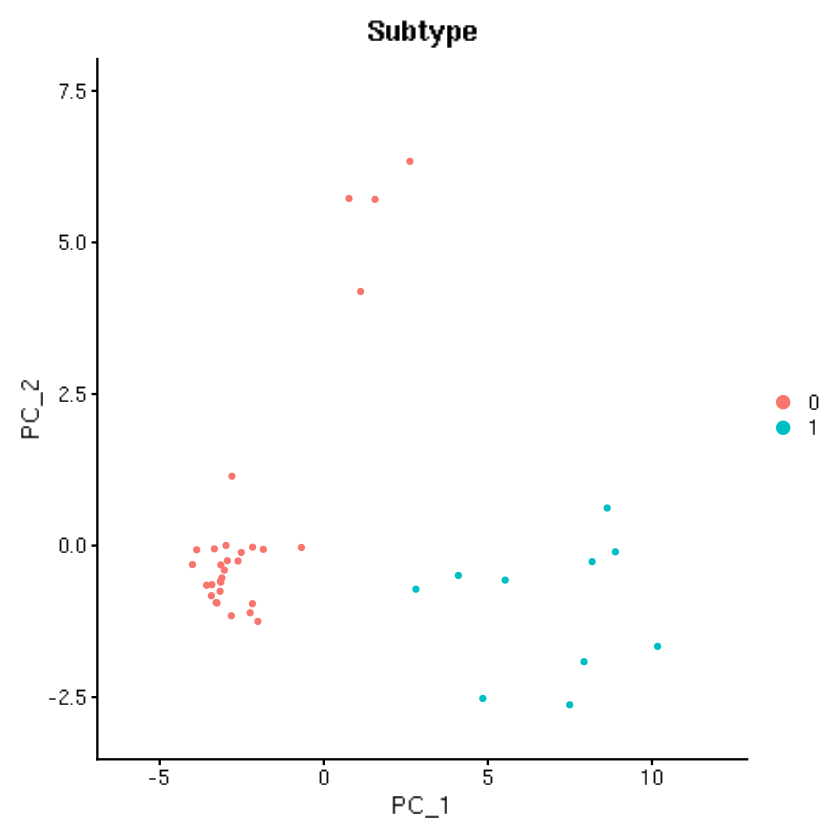

In [79]:
DimPlot(gautier_mns, reduction = "pca") + ggtitle("Subtype") + xlim(-6,12) + ylim(-3,7.5) + theme(plot.title = element_text(hjust = 0.5))

### Figure 1D (top, right)

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



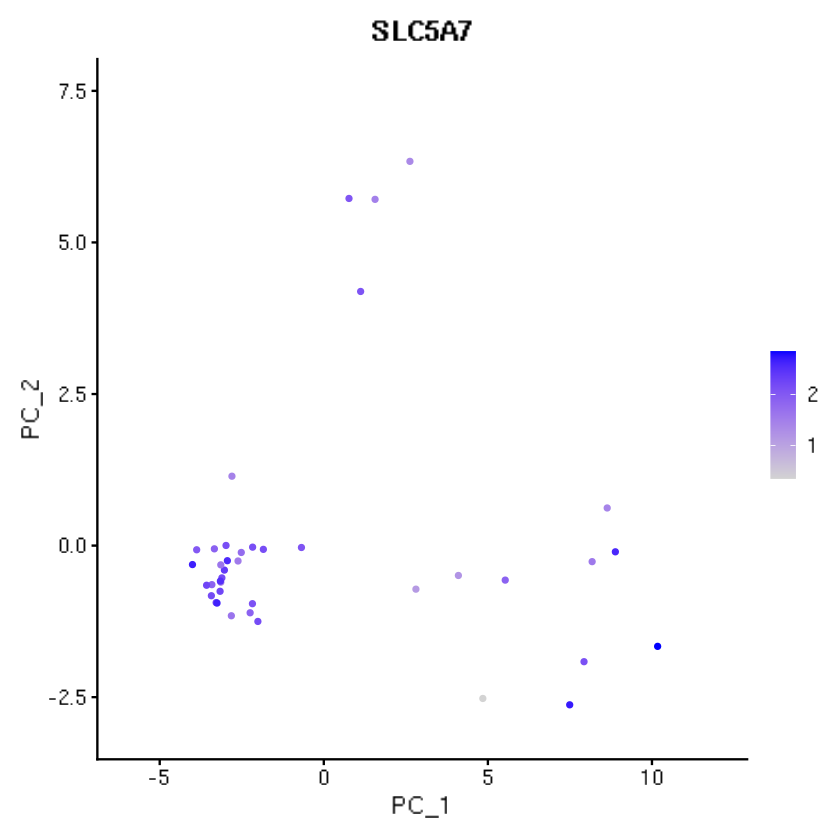

In [80]:
slc5a7_pca <- FeaturePlot(gautier_mns, reduction = "pca", features = c("SLC5A7")) + xlim(-6,12) + ylim(-3,7.5)
slc5a7_pca

### Figure 1D (bottom, left)

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



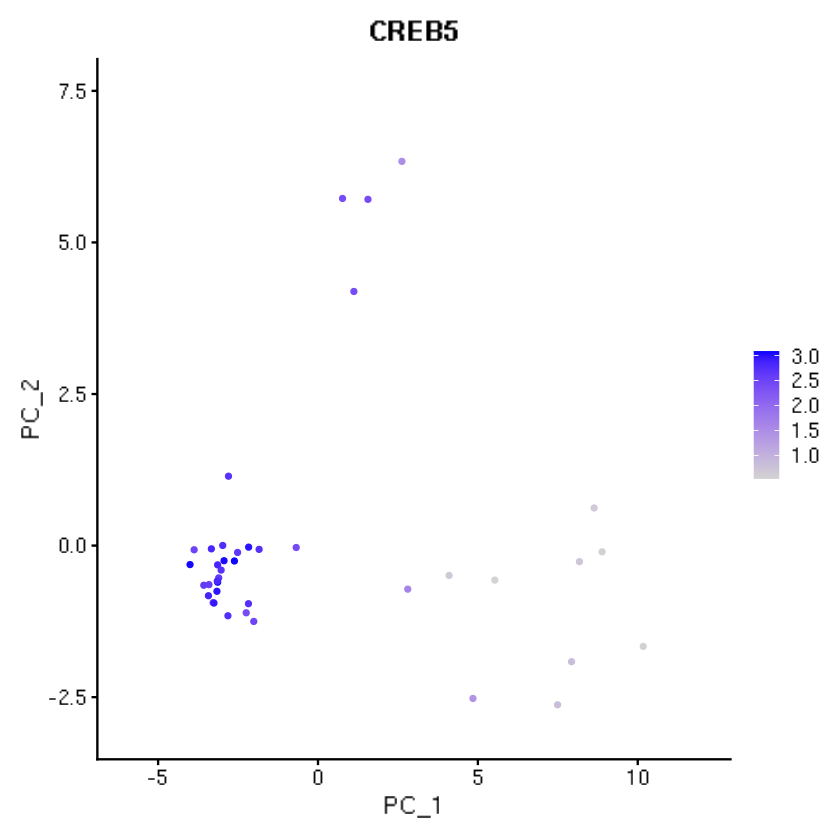

In [81]:
creb5_pca <- FeaturePlot(gautier_mns, reduction = "pca", features = c("CREB5")) + xlim(-6,12) + ylim(-3,7.5)
creb5_pca

### Figure 1D (bottom, right)

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



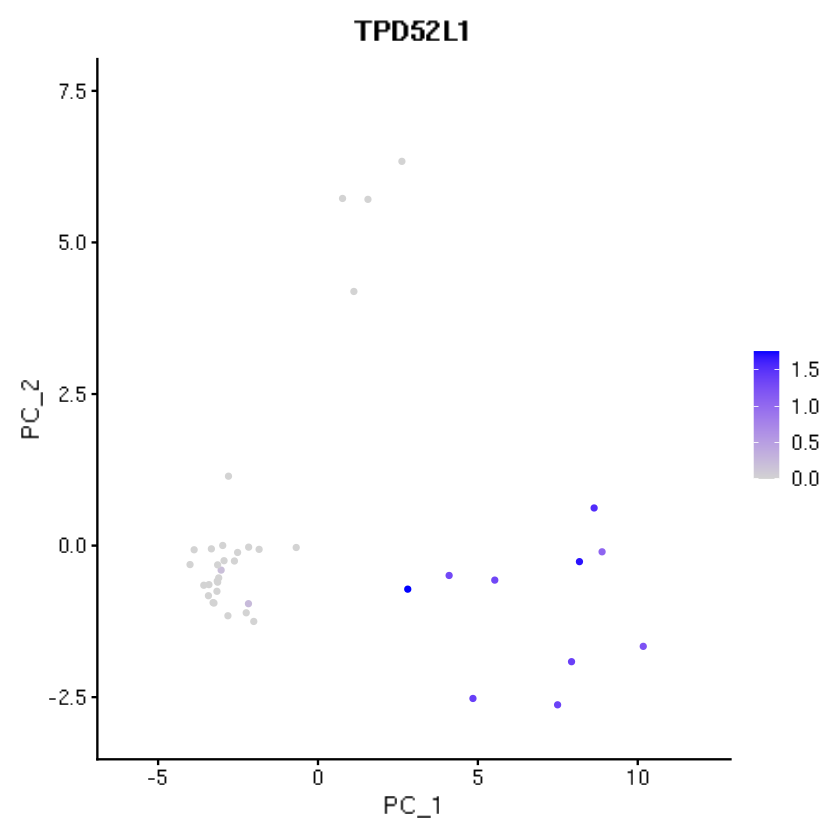

In [82]:
tpd52l1_pca <- FeaturePlot(gautier_mns, reduction = "pca", features = c("TPD52L1")) + xlim(-6,12) + ylim(-3,7.5)
tpd52l1_pca

In [83]:
gautier_mns$motor_neuron_subtype <- ifelse(gautier_mns$seurat_clusters == "0", yes = "Gamma", no = "Alpha")

In [84]:
Idents(gautier_mns) <- gautier_mns$motor_neuron_subtype

### Figure 1D (top, left)

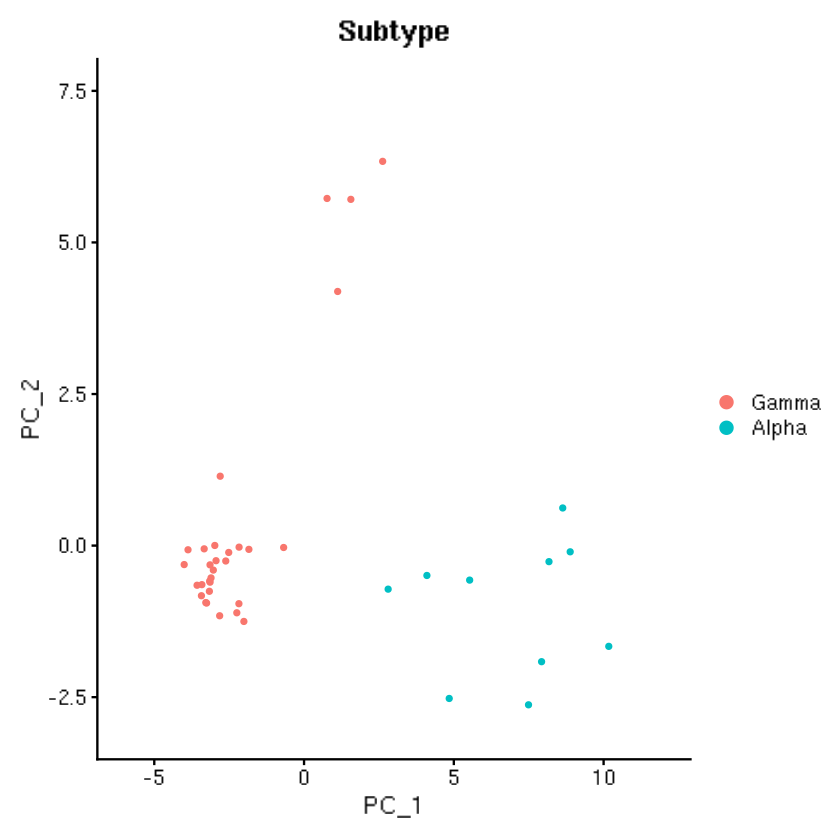

In [85]:
subtype_pca <- DimPlot(gautier_mns, reduction = "pca") + ggtitle("Subtype") + xlim(-6,12) + ylim(-3,7.5) + theme(plot.title = element_text(hjust = 0.5))
subtype_pca

In [86]:
ggsave(subtype_pca, filename = paste(fig_dir, 'subtype_pca.svg', sep='/'), device='svg', width = 3.56113, height = 2.75, units = "in")
ggsave(slc5a7_pca, filename = paste(fig_dir, 'slc5a7_pca.svg', sep='/'), device='svg', width = 3.061, height = 2.75, units = "in")
ggsave(creb5_pca, filename = paste(fig_dir, 'creb5_pca.svg', sep='/'), device='svg', width = 3.2, height = 2.75, units = "in")
ggsave(tpd52l1_pca, filename = paste(fig_dir, 'tpd52l1_pca.svg', sep='/'), device='svg', width = 3.2, height = 2.75, units = "in")

## Volcano plot - alpha vs. gamma

In [87]:
alpha_gamma_volcano_markers <- FindMarkers(gautier_mns, ident.1 = "Alpha", ident.2 = "Gamma", logfc.threshold=0, min.pct=0)
alpha_gamma_volcano_markers$p_val_adj = p.adjust(alpha_gamma_volcano_markers$p_val, method='fdr')

### Table S2

In [88]:
write.csv(alpha_gamma_volcano_markers, file=paste(csv_dir, 'Table S2.csv', sep='/'))

### Figure 1E

In [89]:
alpha_gamma_volcano_markers$gene <- rownames(alpha_gamma_volcano_markers)
rownames(alpha_gamma_volcano_markers) <- NULL

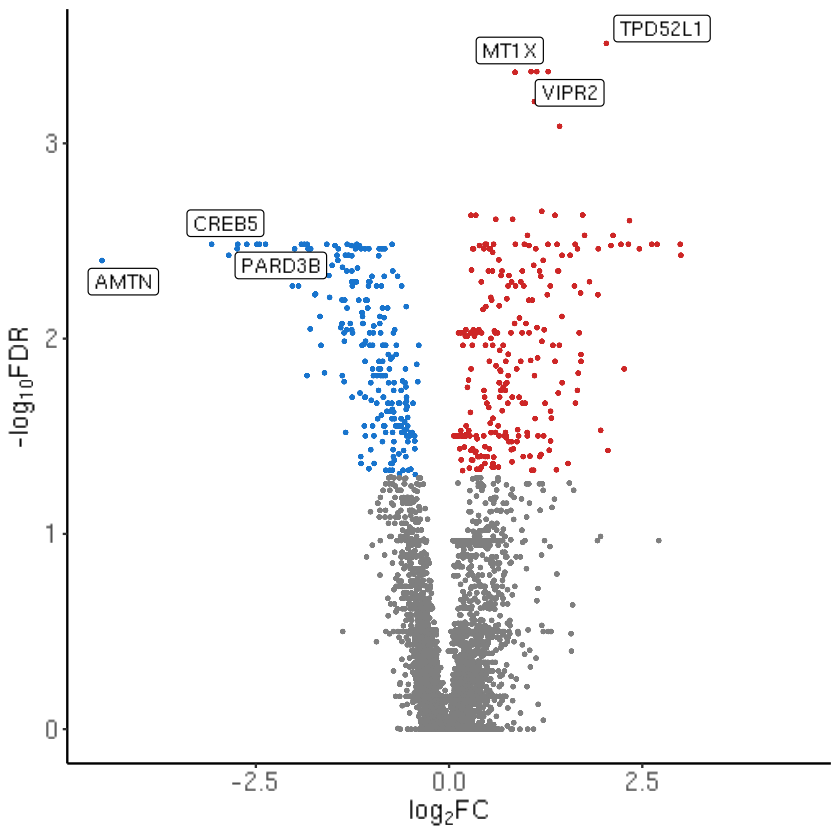

In [90]:
alpha_gamma_volcano_plot <- make_volcano_plot(alpha_gamma_volcano_markers, 0, labeled_genes = c('PARD3B', 'CREB5', 'AMTN', 'TPD52L1', 'VIPR2', 'MT1X'), p_val_cutoff = 0.05) + ylab(label = expression("-log"[10]*"FDR"))
alpha_gamma_volcano_plot <- rasterize(alpha_gamma_volcano_plot, layers="Point", dpi=500) + NoLegend()
alpha_gamma_volcano_plot

In [91]:
ggsave(alpha_gamma_volcano_plot, filename = paste(fig_dir, 'alpha_gamma_volcano_plot.svg', sep='/'), device='svg', width = 6.4, height = 4.848, units = "in")

## Save objects

In [92]:
saveRDS(gautier, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier.rds')
saveRDS(gautier_prop_intronic, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_prop_intronic.rds')
saveRDS(gautier_neurons, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_neurons.rds')
saveRDS(gautier_mns, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_mns.rds')

## Load objects

In [ ]:
gautier <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier.rds')
gautier_prop_intronic <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_prop_intronic.rds')
gautier_neurons <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_neurons.rds')
gautier_mns <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_mns.rds')